# PyBaMM Demo

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/"


# Set Parameters and Expansion Functions

In [2]:
def nmc_volume_change_mohtat(sto,c_s_max):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto,c_s_max):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change


def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": 7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,   
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
            # Initializing Particle Concentration
            # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
            # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
        },
        check_already_exists=False,
    )
    return parameter_values

parameter_values = get_parameter_values()

## Search Parameters

In [3]:
parameter_values.search("temperature")

Ambient temperature [K]	298.15
Initial temperature [K]	298.15
Reference temperature [K]	298.15


# Set Cell No

In [4]:
cell = 1

## Read Cell data

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [6]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

# Set PyBaMM experiment

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_c+" until 3V", )

    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "false",
        # "pressure driven porosity": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()

In [8]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

## Set Additional Parameters

In [9]:
Temp = 25
par_val = [4.0312e-08,1.8157e-07,1.0776,2.3586e-09,-4.9170e-09,-1.4406e-09]
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1],
        "Positive electrode LAM constant proportional term 2 [s-1]": par_val[5],
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[4],
        "Positive electrode LAM constant exponential term": par_val[2],
        "Negative electrode LAM constant exponential term": par_val[2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)

In [10]:
spm.variables.search("overpotential")

Negative electrode SEI reaction overpotential
Negative electrode SEI reaction overpotential [V]
Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode reaction overpotential
Negative electrode reaction overpotential [V]
Positive electrode reaction overpotential
Positive electrode reaction overpotential [V]
SEI film overpotential
SEI film overpotential [V]
X-averaged SEI film overpotential
X-averaged SEI film overpotential [V]
X-averaged battery concentration overpotential [V]
X-averaged battery reaction overpotential [V]
X-averaged concentration overpotential
X-averaged concentration overpotential [V]
X-averaged electrolyte overpotential
X-averaged electrolyte overpotential [V]
X-averaged negative electrode lithium plating reaction overpotential
X-averaged negative electrode lithium plating reaction overpotential [V]
X-averaged negative electrode reaction overpotential
X-averaged negative electrode reac

# Simulate

In [11]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=1)

## Search for Variables

In [12]:
spm.variables.search("sei")

Fraction of Li in SEI
Inner SEI concentration [mol.m-3]
Inner SEI interfacial current density
Inner SEI interfacial current density [A.m-2]
Inner SEI on cracks concentration [mol.m-3]
Inner SEI on cracks interfacial current density
Inner SEI on cracks interfacial current density [A.m-2]
Inner SEI on cracks thickness
Inner SEI on cracks thickness [m]
Inner SEI thickness
Inner SEI thickness [m]
Loss of capacity to SEI [A.h]
Loss of capacity to SEI on cracks [A.h]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Negative electrode SEI interfacial current density
Negative electrode SEI interfacial current density [A.m-2]
Negative electrode SEI on cracks interfacial current density
Negative electrode SEI on cracks interfacial current density [A.m-2]
Negative electrode SEI on cracks volumetric interfacial current density
Negative electrode SEI on cracks volumetric interfacial current density [A.m-3]
Negative electrode SEI reaction overpotential
Negative electrode SEI react

# Quick Plot

In [13]:
sol_0.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=4.831371265654666, step=0.04831371265654666)…

In [14]:
output_variables = ["Terminal voltage [V]"]
sol_0.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=4.831371265654666, step=0.04831371265654666)…

In [15]:
out_variables = ["Electrolyte concentration [mol.m-3]"]
sol_0.plot(output_variables=out_variables)
# plt.savefig(fig_DIR +'electrolyte_conc_porosity_0.png')

interactive(children=(FloatSlider(value=0.0, description='t', max=4.831371265654666, step=0.04831371265654666)…

In [16]:
sol_0.plot([["Electrode current density", "Electrolyte current density"], "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=4.831371265654666, step=0.04831371265654666)…

# Define plotting variables

In [17]:
t = sol_0["Time [s]"].entries
I = sol_0["Current [A]"].entries
Q = sol_0['Discharge capacity [A.h]'].entries
Vt = sol_0["Terminal voltage [V]"].entries
exp = 30e6*sol_0["Cell thickness change [m]"].entries
exp_n = 30e6*sol_0["Negative electrode thickness change [m]"].entries
exp_p = 30e6*sol_0["Positive electrode thickness change [m]"].entries
ee_p = sol_0["X-averaged positive electrode porosity"].entries
ee_n = sol_0["X-averaged negative electrode porosity"].entries
ee_s = sol_0["X-averaged separator porosity"].entries
j_n = sol_0["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p = sol_0["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

x = sol_0["x [m]"].entries
c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries

Text(0, 0.5, 'Voltage [V]')

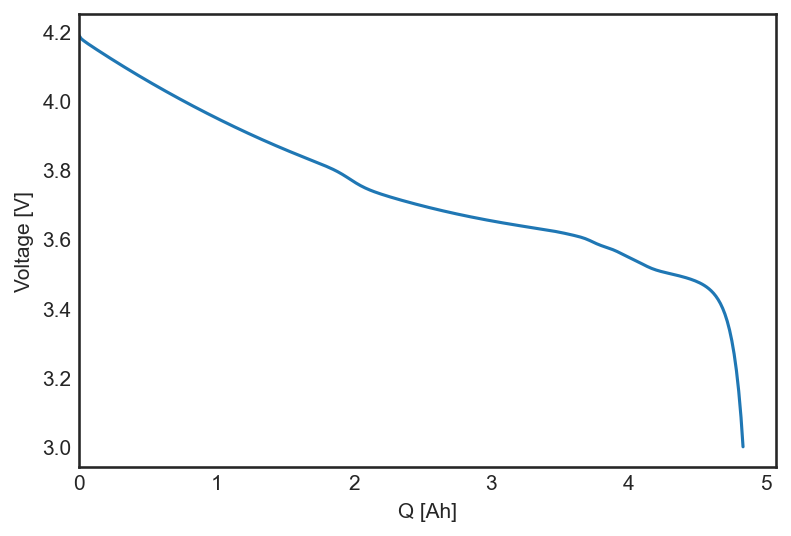

In [18]:
plt.figure()
plt.plot(Q,Vt)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Voltage [V]')

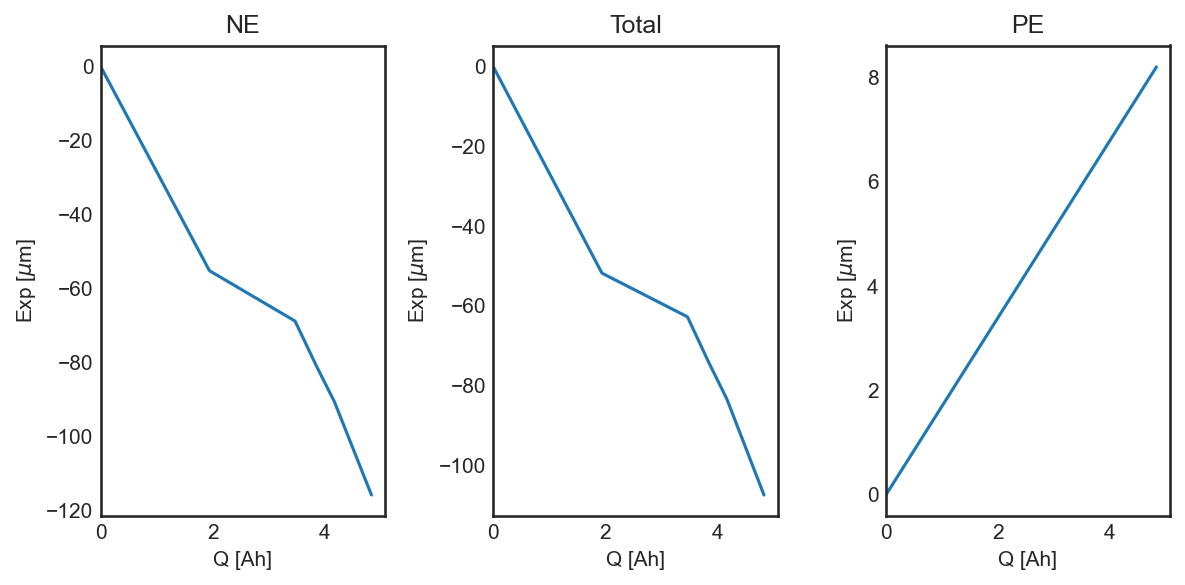

In [19]:
fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1,3,1)
ax1.plot(Q,exp_n)
ax1.set_xlim(left=0)
ax1.set_xlabel('Q [Ah]')
ax1.set_ylabel('Exp [$\mu$m]')
ax1.set_title('NE')
ax2 = plt.subplot(1,3,2)
ax2.plot(Q,exp)
ax2.set_xlim(left=0)
ax2.set_xlabel('Q [Ah]')
ax2.set_title('Total')
ax2.set_ylabel('Exp [$\mu$m]')
ax3 = plt.subplot(1,3,3)
ax3.plot(Q,exp_p)
ax3.set_xlim(left=0)
ax3.set_xlabel('Q [Ah]')
ax3.set_ylabel('Exp [$\mu$m]')
ax3.set_title('PE')
fig.tight_layout()